# Training an intents classification model

Define constants

In [1]:
from os import getcwd, path
import sys
import matplotlib.pyplot as plt
import numpy as np

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

DATA_UTILS = path.join(BASE_PATH, 'common/data_utils.py')
TRAIN_PATH = path.join(BASE_PATH, 'kc_data.json')
CLASSES_FILE = path.join(BASE_PATH, 'classes.json')

from text_classification.fast_text.train import trainIters

In [2]:
exec(open(DATA_UTILS).read())

Use functions from the utils to extract and preprocess the training data
Refer to `kc_data.json` for the sample data format
`get_data_pairs` is then used to parse data into a tuple of `([list_of_sentences], [list_of_labels])`

In [3]:
X_data, y_data = get_data_pairs(data_from_json(TRAIN_PATH))

classes = list(set(y_data))
num_classes = len(classes)

X_train = X_data
y_train = np.array([
    classes.index(item)
    for item in y_data
], dtype='float32')

Plot the training data

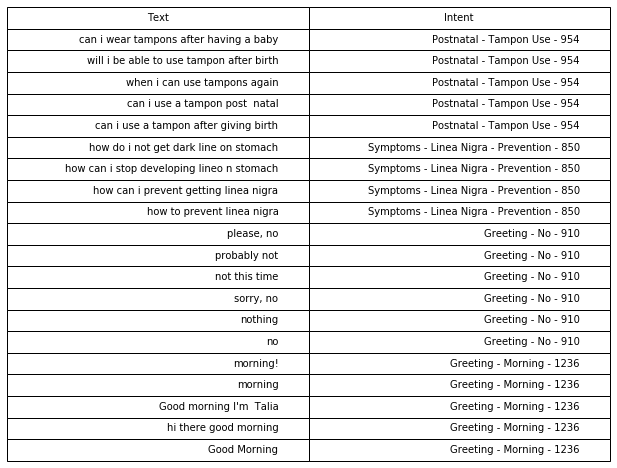

In [4]:
cell_text = [
    [item, y_data[idx] + ' - ' + str(int(y_train[idx]))] 
    for (idx, item) in enumerate(X_train)
]
plt.table(cellText=cell_text[:20],
          colLabels=['Text', 'Intent'],
          loc='center') \
   .scale(1.8,1.8)
plt.axis('off')
plt.show()

In [5]:
print('Number of samples: %s, classes: %s' % (len(X_train), num_classes))

Number of samples: 10256, classes: 1427


Save the classes descriptions as json

In [6]:
import json

with open(CLASSES_FILE, 'w') as classes_file:
    json.dump(classes, classes_file)

Start training the classification model and save

In [7]:
training_data = [(item, y_train[idx]) for idx, item in enumerate(X_train)]

model = trainIters(training_data, classes, n_iters=25, log_every=5, verbose=1, learning_rate=1e-3, batch_size=64)

Training started
Importing /Users/2359media/Documents/botbot-nlp/data/glove/glove.6B.300d.pickle...
1m 51s (- 7m 24s) (5 20%) 1127.8918 - acurracy: 0.2462
3m 45s (- 5m 38s) (10 40%) 796.3300 - acurracy: 0.7267
5m 16s (- 3m 31s) (15 60%) 345.2390 - acurracy: 0.8796
6m 45s (- 1m 41s) (20 80%) 159.1288 - acurracy: 0.9107
8m 19s (- 0m 0s) (25 100%) 97.8703 - acurracy: 0.9204


Test the trained model

In [17]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from common.utils import argmax

from text_classification.fast_text.model import sentence_vector

TEST_SENTENCE = 'I have a fever'

result = model(Variable(torch.FloatTensor([sentence_vector(TEST_SENTENCE)])))
result = F.softmax(result, dim=1)
max_idx = argmax(result)
print((classes[max_idx], result[0][max_idx]))

('Prenatal - Medical - Flu', Variable containing:
 0.3738
[torch.FloatTensor of size 1]
)


Getting the top 5 results

In [24]:
from common.utils import to_scalar

topk_probs, topk_idxs = result.topk(5, dim=1)

for idx, result_idx in enumerate(topk_idxs[0]):
    print((classes[to_scalar(result_idx)], topk_probs[0][idx]))

('Prenatal - Medical - Flu', Variable containing:
 0.3738
[torch.FloatTensor of size 1]
)
('SmallTalk - DatingQuestion-Yes', Variable containing:
 0.1175
[torch.FloatTensor of size 1]
)
('Symptoms - Breast Growth - Period Tender', Variable containing:
1.00000e-02 *
  7.5981
[torch.FloatTensor of size 1]
)
('Prenatal - Medical - MentalHealth - Depression - Level 3', Variable containing:
1.00000e-02 *
  3.1018
[torch.FloatTensor of size 1]
)
('Symptoms - Breast Lumps - Normal? - Lvl2', Variable containing:
1.00000e-02 *
  2.6146
[torch.FloatTensor of size 1]
)
